# Using Machine Learning to Analyze and Predict Trends in Stocks - Technology Sector

## Lian Martin
### December 2021

## Introduction

Everybody loves to talk about their stocks and investments on a good day, but will turn their head to look out the window if you bring them up on a bad day. In the modern age, people are investing their spare funds in stocks or cryptocurrencies, whether that be to join in on the hype and be part of the current trend, or to go all-in and retire at the young age of 30.

What if we were able to predict the ebb and flow of the stock market? What if we used our handy-dandy computational modeling techniques to do what no one ever has before: successfully predict the stock market?

I will be using Tensor Flow deep learning to analyze stocks in the technology sector. The technology sector is vast, comprising of companies that engage in the design, development, and support of computer operating systems and application.

Facebook, Amazon, Apple, Netflix, and Alphabet (Google) are sometimes grouped together as the FAANG stocks. These companies dominate their industries, and their stocks have produced impressive returns over the past few years. I will specifically be analyzing AAPL, AMZN, MSFT, and GOOG.

As these companies are some of the largest market capitalizations in the world, we are provided with lots of data. Let's analyze data from 2010-2020 in daily intervals. We will split 2010-2018 into train-test data and treat 2018-2020 as "future" for testing the model's predictive capabilities. 

## Load in Technology Sector Data

By using the `yahoofinancials` package, we can download historical stock data for a specified time range. We begin by loading in financial data for the technology sector using YahooFinancials

In [44]:
#!pip install yahoofinancials
#!pip install -q -U keras-tuner
#!pip install yfinance
#!pip install tensorflow

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from yahoofinancials import YahooFinancials
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [46]:
#Load in financial data for the technology sector
start = '2010-01-01'
end = '2018-01-01'

ticker_syms =['AAPL','AMZN', 'MSFT','GOOG']
yahoo_financials = YahooFinancials(ticker_syms)

data = yahoo_financials.get_historical_price_data(start_date=start, 
                                                  end_date=end, 
                                                  time_interval='daily')

stocks_tech = pd.DataFrame( { i:pd.DataFrame(data[i]['prices'])['close'] for i in ticker_syms} )

stocks_tech

,AAPL,AMZN,MSFT,GOOG
0,7.643214,6.695000,30.950001,312.204773
1,7.656429,6.734500,30.959999,310.829926
2,7.534643,6.612500,30.770000,302.994293
3,7.520714,6.500000,30.450001,295.940735
4,7.570714,6.676000,30.660000,299.885956
...,...,...,...,...
2008,43.752499,58.417999,85.510002,1060.119995
2009,42.642502,58.838001,85.400002,1056.739990
2010,42.650002,59.112999,85.709999,1049.369995
2011,42.770000,59.305000,85.720001,1048.140015


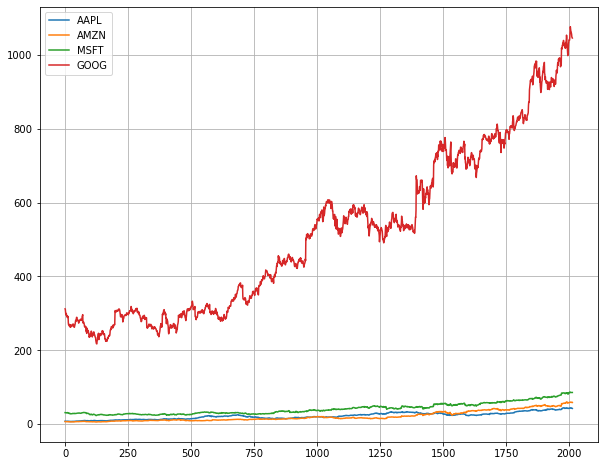

In [47]:
plt.figure(figsize=[10,8])
plt.plot(stocks_tech)
plt.legend(['AAPL', 'AMZN', 'MSFT', 'GOOG'])
plt.grid()

In [48]:
#Load data for each company

goog = pd.DataFrame(pd.DataFrame(data['GOOG']['prices']) )
amzn = pd.DataFrame(pd.DataFrame(data['AMZN']['prices']) )
aapl = pd.DataFrame(pd.DataFrame(data['AAPL']['prices']) )
msft = pd.DataFrame(pd.DataFrame(data['MSFT']['prices']) )

#goog
#goog.info()

## Linear Regression TensorFlow

Tensorflow is an open-source computation library made by Google. Ironically, I analyze Google's stock in this section. Tensorflow is commonly used for deep learning models. In Deep Learning, Recurrent Neural Networks (RNN) are a family of neural networks that excels in learning from sequential data. A class of RNN that has found practical applications is Long Short-Term Memory (LSTM) because it is robust against the problems of long-term dependency.

To begin, we need to prepare our data. Scaling values is important for normal distribution of individual features. I choose to scale my values so that they all fit between 0 and 1. That is, the lowest value stock in the data will have a value of 0 and the highest value stock will have a value of 1.

In [49]:
#Prepare data

#scale values, so they fit between 0 and 1

scaler = MinMaxScaler(feature_range = (0,1))

#Only transforming the close because we want to predict the closing price

scaled_data = scaler.fit_transform(goog['close'].values.reshape(-1,1))

Now it is time to split our data into train and test. Since we want our model to learn the closing price without depending on other features in our data, train_test_split function will not work. I take the first 60 days of data to use as our initial training set.

In [50]:
prediction_days = 60 #how many days to base our prediction on

# Train and test

x_train = []
y_train = []

#count from 60 index until last index
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0]) #60 values
    y_train.append(scaled_data[x, 0]) # the 61st
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #reshape so data works with neural network

#len(x_train)
#len(y_train)

Now it is time to build the model. Each LSTM layer is followed by a dropout layer. The LSTM layer will choose different implementations to maximize the performance. The dropout layer applies dropout to the input. This is important at each step during training, as it helps prevent overfitting. The dense layer is the final layer, which is our output layer.

In [51]:
#Build model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1))) #play with units, more units = more training, possibly overfit
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1)) #Prediction of the next closing value

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 36, batch_size = 32)

Epoch 1/36
62/62 [==============================] - 7s 42ms/step - loss: 0.0179
Epoch 2/36
62/62 [==============================] - 3s 40ms/step - loss: 0.0034
Epoch 3/36
62/62 [==============================] - 3s 40ms/step - loss: 0.0026
Epoch 4/36
62/62 [==============================] - 3s 46ms/step - loss: 0.0023
Epoch 5/36
62/62 [==============================] - 3s 44ms/step - loss: 0.0028
Epoch 6/36
62/62 [==============================] - 3s 49ms/step - loss: 0.0019
Epoch 7/36
62/62 [==============================] - 3s 50ms/step - loss: 0.0020
Epoch 8/36
62/62 [==============================] - 3s 44ms/step - loss: 0.0019
Epoch 9/36
62/62 [==============================] - 3s 44ms/step - loss: 0.0022
Epoch 10/36
62/62 [==============================] - 3s 43ms/step - loss: 0.0019
Epoch 11/36
62/62 [==============================] - 3s 43ms/step - loss: 0.0017
Epoch 12/36
62/62 [==============================] - 3s 49ms/step - loss: 0.0018
Epoch 13/36
62/62 [==================

In [52]:
#model.save()

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

## Testing the Model Accuracy

Hurray! We have a working model. It is time to check how well the model performs. I test the model accuracy on the exisiting data.

To begin, we load the test data, which are stocks from 2018-2020.

In [54]:
#Load test data

start = '2018-01-02'
end = '2020-01-01'

data = yahoo_financials.get_historical_price_data(start_date=start, 
                                                  end_date=end, 
                                                  time_interval='daily')

test_goog = pd.DataFrame(pd.DataFrame(data['GOOG']['prices']) ) #data to see how well the model performs on the testing data
actual_prices = test_goog['close'].values
total_dataset = pd.concat((goog['close'], test_goog['close']), axis = 0) #combines training data and testing data

model_inputs = total_dataset[len(total_dataset) - len(test_goog) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)
#model_inputs

To make predictions on our test data, we repeat the process from above on the test data. We do not have y test values because we have the actual stock prices. Since our predicted prices are scaled, we need to inverse transform them.

In [55]:
#Make predictions on test data

#Repeat process from above for test data
#We do not have y test because we have the actual stock prices

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) #reshape so has the same format
                    
predicted_prices = model.predict(x_test)
                    
#Our predicted prices are going to be scaled so we need to transform them
                    
predicted_prices = scaler.inverse_transform(predicted_prices) 

16/16 [==============================] - 1s 21ms/step


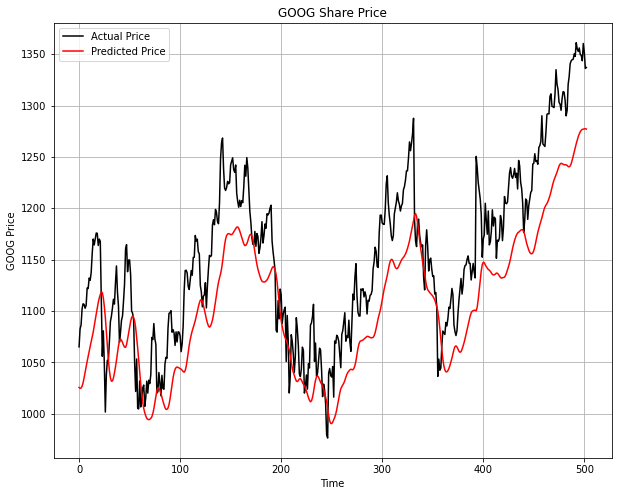

In [56]:
#PLot the test predictions
plt.figure(figsize = [10, 8])
plt.plot(actual_prices, color = 'black', label = 'Actual Price')
plt.plot(predicted_prices, color = 'red', label = 'Predicted Price')
plt.title('GOOG Share Price')
plt.xlabel('Time')
plt.ylabel('GOOG Price')
plt.legend()
plt.grid()

### Predict the Next Day

In [57]:
# predict the future day

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

#print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print('Prediction:', prediction)

1/1 [==============================] - 1s 976ms/step
Prediction: [[1276.1119]]


## Conclusion

Training a Recurrent Neural Network model was difficult. To begin with, this was all exploratory. I had to do a fair amount of research into RNN’s, in particular, LSTM’s. In the model, each LSTM layer is followed by a dropout layer. The LSTM layer chooses different implementations to maximize the performance. The dropout layer applies dropout to the input. This means that the dropout layer prevents our model from overfitting. My model excelled in predicting the closing price of the sector and stocks that I chose, but future testing could include predicting other sectors/stocks to verify the model's abilities.

Encapsulating the stock market’s wild nature solidified one thing: the day to day prediction of the stock market is very difficult to do. This should come as no surprise: after all if it was easy, wouldn’t everyone have these models? With more time and more experience I would hope to introduce more features that are less obvious, external factors such as global events can have a huge impact on the market while being more difficult to explain in modeling.